# CIFAR-10 Project

CAS on Advanced Machine Learning  
Data Science Lab, University of Bern, 2024

## Installations

In [1]:
# Install all required packages from requirements.txt
# Uncomment the line below to install:

# %pip install -r requirements.txt

# Note: After installation, restart the kernel (Kernel → Restart)

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import einops as eo
import pathlib as pl
from time import time as timer

import tqdm.auto as tqdm

import torch
from torchvision import datasets, transforms
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.v2 as T

import sys
is_colab = 'google.colab' in sys.modules

%matplotlib inline

## Setup

In [3]:
if is_colab:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    root_path = '/content/drive/My Drive/Colab Notebooks/CAS_AML_M3'
    root_path = pl.Path(root_path)
    root_path.mkdir(exist_ok=True, parents=True)
else:
    root_path = pl.Path.cwd()

In [4]:
def get_device():
    """Get available device (CUDA GPU, MPS for Mac M1/M2, or CPU)"""
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print(f'Using CUDA GPU: {torch.cuda.get_device_name(0)}')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print('Using MPS (Apple Silicon GPU)')
    else:
        device = torch.device('cpu')
        print('Using CPU')
    return device

device = get_device()

Using MPS (Apple Silicon GPU)


In [5]:
def set_seed(seed=42):
    """
    Set random seeds for reproducibility across all random number generators.
    
    Purpose:
        Ensures that model initialization, data shuffling, and other random operations
        produce the same results across different runs. Critical for:
        - Comparing hyperparameter changes fairly
        - Debugging issues consistently
        - Educational purposes (students get same results)
        - Scientific reproducibility
    
    Args:
        seed: Integer seed value (default: 42)
    
    Note:
        Perfect reproducibility on GPU can be challenging due to non-deterministic
        CUDA operations. For bit-exact reproducibility, set:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        (This will slow down training significantly)
    
    Fact-checked: PyTorch Reproducibility Documentation (Official, 2025)
    """
    import random
    import numpy as np
    import torch
    
    # Python's built-in random module
    random.seed(seed)
    
    # NumPy random number generator
    np.random.seed(seed)
    
    # PyTorch random number generator (CPU)
    torch.manual_seed(seed)
    
    # PyTorch random number generator (CUDA GPUs)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # MPS (Apple Silicon) - manual_seed helps but no deterministic mode yet
    if torch.backends.mps.is_available():
        # MPS backend doesn't have separate seeding, torch.manual_seed() covers it
        pass
    
    print(f"✓ Random seed set to {seed} for reproducibility")
    print(f"  - Python random: seeded")
    print(f"  - NumPy: seeded")
    print(f"  - PyTorch: seeded")
    if torch.cuda.is_available():
        print(f"  - CUDA: seeded")

# Set the seed globally
set_seed(42)

✓ Random seed set to 42 for reproducibility
  - Python random: seeded
  - NumPy: seeded
  - PyTorch: seeded


In [6]:
# Image Visualization Functions from Dr. Mykhailo Vladymyrov and Matteo Boi

COLORS = {
    'encoder': '#FF6B6B',
    'decoder': '#4ECDC4',
    'latent': '#45B7D1',
    'original': '#96CEB4',
    'reconstructed': '#FECA57',
    'noisy': '#FF9FF3'
}

def to_np_showable(pt_img):
    """Convert PyTorch tensor to displayable numpy array"""
    np_im = pt_img.detach().cpu().numpy()
    if len(np_im.shape) == 4:
        np_im = np_im[0]
    if np_im.shape[0] > 3:
        np_im = np_im[-3:]
    return (eo.rearrange(np_im, 'c h w -> h w c')/2+.5).clip(0., 1.)

def plot_im(im, title="Image", is_torch=True, figsize=(6, 6)):
    """Plot a single image with enhanced styling"""
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(to_np_showable(im) if is_torch else im, cmap='gray')
    ax.set_title(title, fontsize=14, pad=15)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def plot_im_samples(ds, n=5, is_torch=False, title="Sample Images", figsize=None):
    """Plot multiple images in a row with enhanced styling"""
    if figsize is None:
        figsize = (3*n, 4)

    fig, axs = plt.subplots(1, n, figsize=figsize)
    fig.suptitle(title, fontsize=16, y=1.02)

    if n == 1:
        axs = [axs]

    for i, image in enumerate(ds[:n]):
        axs[i].imshow(to_np_showable(image) if is_torch else image, cmap='gray')
        axs[i].set_title(f'Sample {i+1}', fontsize=12)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_comparison(original, reconstructed, noisy=None, titles=None, figsize=(15, 5)):
    """Plot comparison between original, noisy (if provided), and reconstructed images"""
    images = [original, reconstructed]
    default_titles = ['Original', 'Reconstructed']

    if noisy is not None:
        images.insert(1, noisy)
        default_titles = ['Original', 'Noisy Input', 'Reconstructed']

    if titles is None:
        titles = default_titles

    n_imgs = len(images)
    fig, axs = plt.subplots(1, n_imgs, figsize=figsize)

    colors = [COLORS['original'], COLORS['noisy'], COLORS['reconstructed']][:n_imgs]

    for i, (img, title, color) in enumerate(zip(images, titles, colors)):
        axs[i].imshow(to_np_showable(img), cmap='gray')
        axs[i].set_title(title, fontsize=14, color=color, fontweight='bold')
        axs[i].axis('off')

        # Add colored border
        for spine in axs[i].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
            spine.set_visible(True)

    plt.tight_layout()
    plt.show()

What is CIFAR-10?
- 50,000 training images + 10,000 test images
- Each image is 32×32 pixels with 3 color channels (RGB)
- 10 classes: plane, car, bird, cat, deer, dog, frog, horse, ship, truck

# Get CIFAR-10 Dataset

In [7]:
data_path = './cifar10'

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True)
cifar10_classes = cifar10.classes


## Display content of the datasets

In [8]:
print(f"Training set size: {len(cifar10)}")
print(f"Test set size: {len(cifar10_test)}")

Training set size: 50000
Test set size: 10000


## Check the images at random

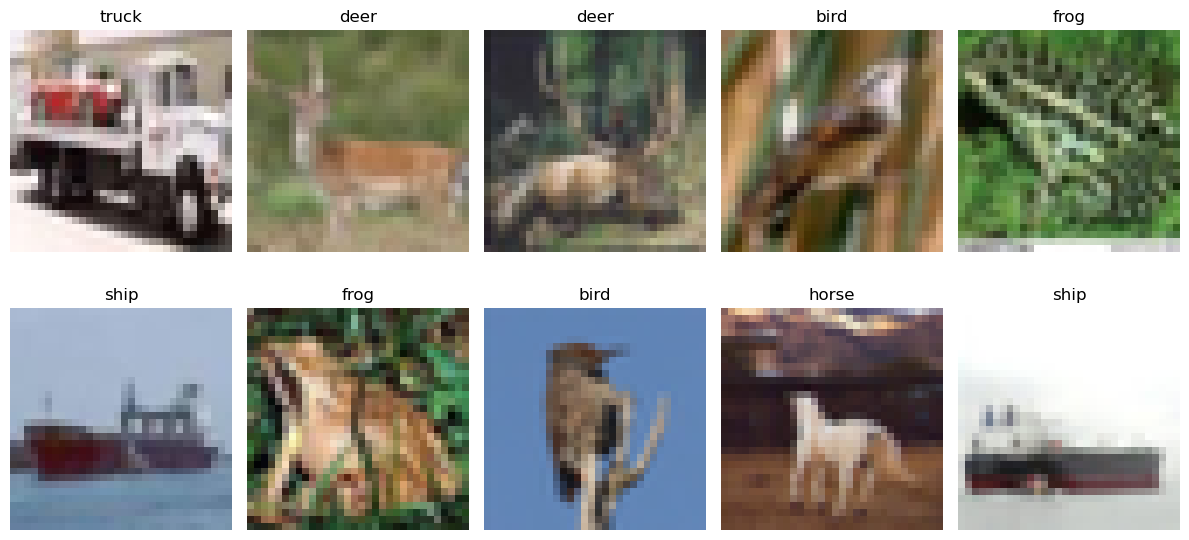

In [9]:
import random

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random.sample(range(len(cifar10)), 10)):
    img, label = cifar10[idx]
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(cifar10_classes[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Load dataset for training

In [10]:
from torch.utils.data import random_split

transform = T.ToTensor()

cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transform # Convert PIL Image (0-255) to PyTorch Tensor (0.0-1.0)
) 

# Split 80/20
train_size = int(0.8 * len(cifar10))
val_size = len(cifar10) - train_size

generator = torch.Generator().manual_seed(42)
cifar10_train, cifar10_val = random_split(cifar10, [train_size, val_size], generator=generator)

cifar10_test = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transform # Convert PIL Image (0-255) to PyTorch Tensor (0.0-1.0)
)
print(f"Train set size: {len(cifar10_train)}")
print(f"Validation set size: {len(cifar10_val)}")
print(f"Test set size: {len(cifar10_test)}")

/Users/homer/_mygit/cas-aml/_Miniforge/install_dir/envs/tensorflow/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Train set size: 40000
Validation set size: 10000
Test set size: 10000


### Display tensor for one image

In [11]:
img_tensor, label = cifar10_train[0]
print(img_tensor)
print(f"Label: {cifar10_classes[label]}")

tensor([[[0.2392, 0.2784, 0.3059,  ..., 0.3059, 0.2784, 0.2275],
         [0.4471, 0.4275, 0.3647,  ..., 0.3216, 0.2784, 0.2353],
         [0.3137, 0.2588, 0.1922,  ..., 0.3686, 0.3608, 0.3176],
         ...,
         [0.0157, 0.0235, 0.0000,  ..., 0.4431, 0.4078, 0.4431],
         [0.0314, 0.0549, 0.0235,  ..., 0.4627, 0.3804, 0.3529],
         [0.1490, 0.1490, 0.1137,  ..., 0.3765, 0.3294, 0.3569]],

        [[0.2235, 0.2431, 0.2745,  ..., 0.2549, 0.2275, 0.1843],
         [0.4275, 0.3922, 0.3412,  ..., 0.2863, 0.2392, 0.2000],
         [0.2980, 0.2353, 0.1922,  ..., 0.3451, 0.3255, 0.2824],
         ...,
         [0.0706, 0.0510, 0.0706,  ..., 0.2980, 0.2196, 0.1922],
         [0.0471, 0.0588, 0.0510,  ..., 0.3020, 0.2314, 0.1765],
         [0.1137, 0.0980, 0.0706,  ..., 0.2000, 0.1647, 0.1922]],

        [[0.2196, 0.2353, 0.2588,  ..., 0.2000, 0.1882, 0.1490],
         [0.4392, 0.4118, 0.3412,  ..., 0.2235, 0.1961, 0.1686],
         [0.2745, 0.2118, 0.1333,  ..., 0.2941, 0.2902, 0.

### Calculate Mean and Std for the dataset

In [12]:
imgs = torch.stack([img_t for img_t ,_ in cifar10],dim=3)

mean = imgs.view(3,-1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

print(f"mean : {mean}")
print(f"std : {std}")


mean : tensor([0.4914, 0.4822, 0.4465])
std : tensor([0.2470, 0.2435, 0.2616])


## Load dataset again with transformation (ToImage / Normalize / RandomHorizontalFlip)

In [13]:
# Because we use than layer
mean = [0.5, 0.5, 0.5]  # List with values, one per RGB channel
std = [0.5, 0.5, 0.5]

# Combine both transformations
transform = T.Compose([
    T.ToImage(),
    T.RandomHorizontalFlip(p=0.5),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean, std)
])

cifar10_norm = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transform
) 

# Split 80/20 with reproducible seed
train_size = int(0.8 * len(cifar10_norm))
val_size = len(cifar10_norm) - train_size

generator = torch.Generator().manual_seed(42)
cifar10_norm_train, cifar10_norm_val = random_split(cifar10_norm, [train_size, val_size], generator=generator)

cifar10_norm_test = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transform
)

print(f"Train set size: {len(cifar10_norm_train)}")
print(f"Validation set size: {len(cifar10_norm_val)}")
print(f"Test set size: {len(cifar10_norm_test)}")

Train set size: 40000
Validation set size: 10000
Test set size: 10000


### Plot normal distribution of pixel before and after normalisation

Sampling 10,000 raw images...
Sampling 10,000 normalized images...


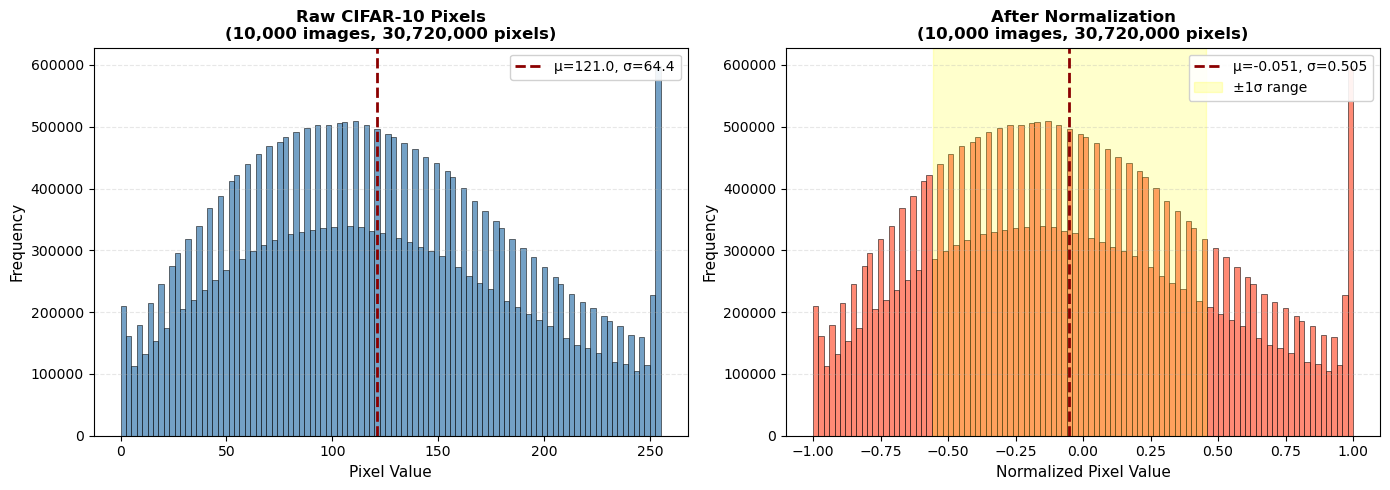

In [14]:
N_SAMPLES = 10000  # Use 10k images for speed (still statistically valid)
BINS = 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

print(f"Sampling {N_SAMPLES:,} raw images...")
raw_pixels = cifar10.data[:N_SAMPLES].flatten()

axes[0].hist(raw_pixels, bins=BINS, color='steelblue',
             alpha=0.75, edgecolor='black', linewidth=0.5)
axes[0].set_title(f"Raw CIFAR-10 Pixels\n({N_SAMPLES:,} images, {len(raw_pixels):,} pixels)",
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel("Pixel Value", fontsize=11)
axes[0].set_ylabel("Frequency", fontsize=11)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Add mean line and annotation
raw_mean = raw_pixels.mean()
raw_std = raw_pixels.std()
axes[0].axvline(raw_mean, color='darkred', linestyle='--', linewidth=2,
                label=f'μ={raw_mean:.1f}, σ={raw_std:.1f}')
axes[0].legend(loc='upper right', fontsize=10, framealpha=0.9)

# --- RIGHT: Normalized pixel distribution ---
print(f"Sampling {N_SAMPLES:,} normalized images...")
norm_pixels = []
for i in range(N_SAMPLES):
    img_tensor, _ = cifar10_norm[i]
    norm_pixels.append(img_tensor.numpy())
norm_pixels = np.array(norm_pixels).flatten()

axes[1].hist(norm_pixels, bins=BINS, color='tomato',
             alpha=0.75, edgecolor='black', linewidth=0.5)
axes[1].set_title(f"After Normalization\n({N_SAMPLES:,} images, {len(norm_pixels):,} pixels)",
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel("Normalized Pixel Value", fontsize=11)
axes[1].set_ylabel("Frequency", fontsize=11)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Add mean line, std range, and annotation
norm_mean = norm_pixels.mean()
norm_std = norm_pixels.std()
axes[1].axvline(norm_mean, color='darkred', linestyle='--', linewidth=2,
                label=f'μ={norm_mean:.3f}, σ={norm_std:.3f}')
axes[1].axvspan(norm_mean - norm_std, norm_mean + norm_std,
                alpha=0.2, color='yellow', label='±1σ range')
axes[1].legend(loc='upper right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()

## Create dataloader

In [15]:
BATCH_SIZE = 512

# Training loader - shuffles data each epoch for better learning
train_loader = torch.utils.data.DataLoader(
    cifar10_norm_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    persistent_workers=False  
)

# Validation loader - for monitoring during training
val_loader = torch.utils.data.DataLoader(
    cifar10_norm_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    pin_memory=True,
    persistent_workers=False
)

# Test loader - ONLY for final evaluation after training
test_loader = torch.utils.data.DataLoader(
    cifar10_norm_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    pin_memory=True,
    persistent_workers=False
)

In [16]:
test_loader

Batch idx: 0
Input imgs: 	type: <class 'torch.Tensor'> 	shape: torch.Size([512, 3, 32, 32])
Labels: 	type: <class 'torch.Tensor'> 	shape: torch.Size([512])


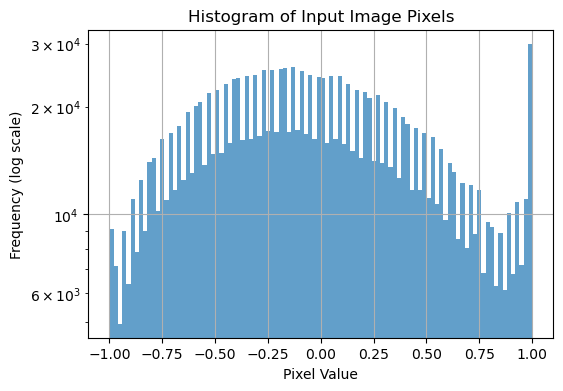

In [17]:
# Iterate over test_loader
for batch_idx, (input_imgs, labels) in enumerate(test_loader):
    print("Batch idx:", batch_idx)
    print("Input imgs:", "\ttype:", type(input_imgs), "\tshape:", input_imgs.shape)
    print("Labels:", "\ttype:", type(labels), "\tshape:", labels.shape)

    # Plot histogram of pixel values
    plt.figure(figsize=(6, 4))
    plt.hist(input_imgs.flatten().cpu().numpy(), bins=100, alpha=0.7)
    plt.yscale('log')
    plt.title("Histogram of Input Image Pixels")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency (log scale)")
    plt.grid(True)
    plt.show()
    
    break 

torch.Size([512, 3, 32, 32]) torch.Size([512])


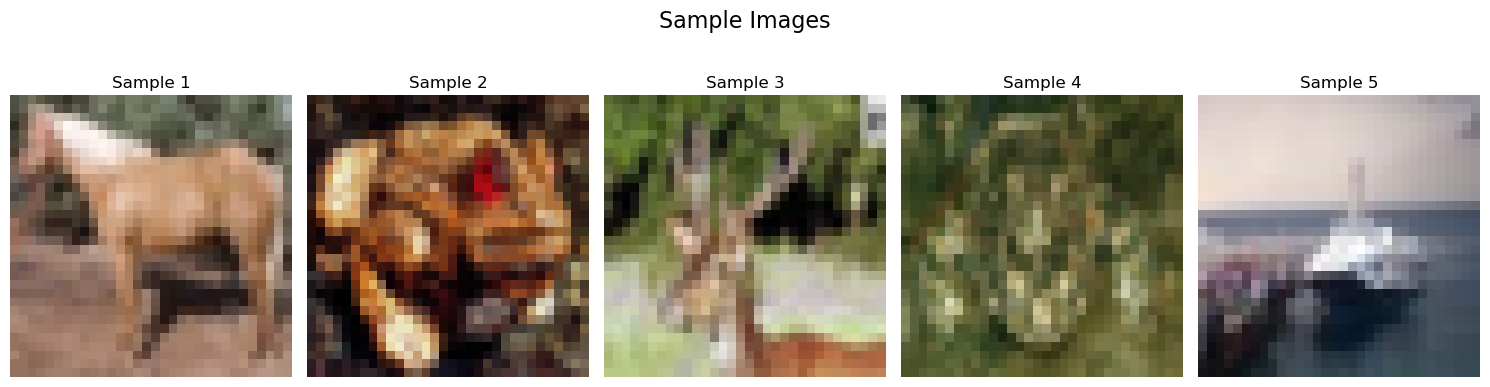

In [18]:
for s in train_loader:
  xs, ys = s
  print(xs.shape, ys.shape)
  break

plot_im_samples(xs, is_torch=True)

In [19]:
# fill array of all preprocessed training samples, converted to numpy:
train_images = []
for batch_idx, (data, target) in enumerate(train_loader):
    train_images.append(data.detach().cpu().numpy())

train_images = np.concatenate(train_images, axis=0)

In [20]:
# get mean and std of an array with numpy:
def get_mean_std(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    return x_mean, x_std

# get min and max of an array with numpy:
def get_min_max(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return x_min, x_max

print ("train_images.shape = ", train_images.shape)
print ("train_images.dtype = ", train_images.dtype)
print ("train_images.mean/std() = ", get_mean_std(train_images))
print ("train_images.min/max() = ", get_min_max(train_images))

train_images.shape =  (39936, 3, 32, 32)
train_images.dtype =  float32
train_images.mean/std() =  (-0.05240644, 0.5032425)
train_images.min/max() =  (-1.0, 1.0)


# VAE Training

## Define VAE model and training steps

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

code_size = 32

class ResidualBlock(nn.Module):
    """
    Residual block with GroupNorm for better VAE training.
    
    Architecture:
        Input → Conv3x3 → GN → ReLU → Conv3x3 → GN → (+Input) → ReLU → Output
               └────────────────────────────────────────────────┘ skip
    """
    def __init__(self, channels):
        super().__init__()
        
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.gn1 = nn.GroupNorm(min(32, channels//4), channels)
        
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.gn2 = nn.GroupNorm(min(32, channels//4), channels)
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.gn2(out)
        
        out = out + residual
        out = self.relu(out)
        
        return out

class ConvVAE(nn.Module):
    """
    Deeper Convolutional VAE with Residual Blocks
    
    Architecture:
      - Encoder: 4 downsampling blocks (32×32 → 16×16 → 8×8 → 4×4 → 2×2)
      - 1 residual block per level (8 total: 4 encoder + 4 decoder)
      - GroupNorm instead of BatchNorm (better for VAEs)
    """
    def __init__(self, code_size):
        super().__init__()

        # Encoder: 4 downsampling blocks + residual blocks
        self.encoder = nn.Sequential(
            # Block 1: 32×32 → 16×16, channels 3→32
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.GroupNorm(8, 32),
            nn.ReLU(inplace=True),
            ResidualBlock(32),
            
            # Block 2: 16×16 → 8×8, channels 32→64
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(inplace=True),
            ResidualBlock(64),
            
            # Block 3: 8×8 → 4×4, channels 64→128
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU(inplace=True),
            ResidualBlock(128),
            
            # Block 4: 4×4 → 2×2, channels 128→256
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.GroupNorm(16, 256),
            nn.ReLU(inplace=True),
            ResidualBlock(256),
            
            nn.Flatten(),  # [B, 256, 2, 2] → [B, 1024]
        )
        
        # Latent space projection (1024 → 64)
        self.fc_mu = nn.Linear(1024, code_size)
        self.fc_logvar = nn.Linear(1024, code_size)

        # Decoder: mirrors encoder (64 → 1024 → spatial)
        self.decoder_input = nn.Linear(code_size, 1024)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 2, 2)),  # [B, 1024] → [B, 256, 2, 2]
            
            # Block 1: 2×2 → 4×4, channels 256→128
            ResidualBlock(256),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU(inplace=True),
            
            # Block 2: 4×4 → 8×8, channels 128→64
            ResidualBlock(128),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(inplace=True),
            
            # Block 3: 8×8 → 16×16, channels 64→32
            ResidualBlock(64),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.GroupNorm(8, 32),
            nn.ReLU(inplace=True),
            
            # Block 4: 16×16 → 32×32, channels 32→3
            ResidualBlock(32),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        """Encode input to latent distribution parameters"""
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = μ + ε * σ"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decode latent vector to reconstruction"""
        x = self.decoder_input(z)
        return self.decoder(x)

    def forward(self, x):
        """Full forward pass: encode → sample → decode"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [22]:
def vae_loss_function(recon_x, x, mu, logvar, beta=2.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kl_loss = torch.mean(kl_loss)
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

In [23]:
# Create test model
test_model = ConvVAE(code_size).to(device)
print(f"\n✓ Model created successfully on {device}")

# Test with dummy input
dummy_input = torch.randn(2, 3, 32, 32).to(device)
print(f"\n✓ Test input shape: {dummy_input.shape}")

# Count parameters
total_params = sum(p.numel() for p in test_model.parameters())
trainable_params = sum(p.numel() for p in test_model.parameters() if p.requires_grad)
print(f"\n✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")

print("\n" + "=" * 60)
print("✓✓✓ All tests passed! Model is ready for training ✓✓✓")
print("=" * 60)


✓ Model created successfully on mps

✓ Test input shape: torch.Size([2, 3, 32, 32])

✓ Total parameters: 4,620,035
✓ Trainable parameters: 4,620,035

✓✓✓ All tests passed! Model is ready for training ✓✓✓


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_reconstruction_samples(model, loader, n=6):
    """
    Display original vs reconstructed samples from the model.
    """
    model.eval()
    imgs, _ = next(iter(loader))
    imgs = imgs[:n].to(device)

    with torch.no_grad():
        outputs, _, _ = model(imgs)

    # Convert tensors to numpy (C,H,W) → (H,W,C)
    imgs_np = imgs.cpu().numpy().transpose(0, 2, 3, 1)
    outputs_np = outputs.cpu().numpy().transpose(0, 2, 3, 1)

    def denorm(x):
        return (x * 0.5) + 0.5  # Maps [-1, 1] → [0, 1]
    
    imgs_np = denorm(imgs_np)
    outputs_np = denorm(outputs_np)
    
    imgs_np = np.clip(imgs_np, 0, 1)
    outputs_np = np.clip(outputs_np, 0, 1)

    # Plot reconstructions
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Reconstruction
        plt.subplot(2, n, i + 1)
        plt.imshow(outputs_np[i])
        plt.axis('off')
        if i == 0:
            plt.ylabel("Reconstructed", fontsize=12)

        # Original
        plt.subplot(2, n, i + n + 1)
        plt.imshow(imgs_np[i])
        plt.axis('off')
        if i == 0:
            plt.ylabel("Original", fontsize=12)

    plt.tight_layout()
    plt.show()

In [25]:
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show_best_and_worst_reconstructions(model, dataloader, device, n=6):
    model.eval()
    errors = []
    originals = []
    reconstructions = []

    with torch.no_grad():
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            recon, _, _ = model(imgs)

            per_image_loss = F.mse_loss(recon, imgs, reduction='none')
            per_image_loss = per_image_loss.view(per_image_loss.size(0), -1).mean(dim=1)

            errors.extend(per_image_loss.cpu().numpy())
            originals.extend(imgs.cpu())
            reconstructions.extend(recon.cpu())

    errors = np.array(errors)
    originals = torch.stack(originals)
    reconstructions = torch.stack(reconstructions)

    best_idxs = np.argsort(errors)[:n]
    worst_idxs = np.argsort(errors)[-n:]

    def plot_examples(title, indices):
        fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
        fig.suptitle(title, fontsize=14)

        for i, idx in enumerate(indices):
            recon_img = reconstructions[idx] * 0.5 + 0.5
            orig_img = originals[idx] * 0.5 + 0.5

            axes[0, i].imshow(recon_img.permute(1, 2, 0).clip(0, 1))
            axes[0, i].axis('off')

            axes[1, i].imshow(orig_img.permute(1, 2, 0).clip(0, 1))
            axes[1, i].axis('off')

        axes[0, 0].set_ylabel("Recon", fontsize=12)
        axes[1, 0].set_ylabel("Original", fontsize=12)
        plt.tight_layout()
        plt.show()

    plot_examples("Best Reconstructions", best_idxs)
    plot_examples("Worst Reconstructions", worst_idxs)


## KL Annealing Strategies for VAE Training

In [26]:
import math
import matplotlib.pyplot as plt
import numpy as np

def linear_annealing(epoch, warmup_epochs=40, max_beta=1.0):
    """
    Linear warmup from 0 to max_beta over warmup_epochs.
    
    Args:
        epoch: Current epoch (0-indexed)
        warmup_epochs: Number of epochs for warmup
        max_beta: Maximum beta value
    
    Returns:
        Current beta value
    """
    if epoch < warmup_epochs:
        return max_beta * (epoch / warmup_epochs)
    return max_beta


## Train loop

### Train parameters and stuff

In [27]:
import time
import torch
import torchvision
import torch.nn.functional as F

print(f"Device : {device}")

# Hyperparameters
num_epochs = 500        
warmup_epochs = 30      
max_beta = 5

# Model and optimizer
model = ConvVAE(code_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler: reduce LR if val loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,
    verbose=True,
    min_lr=1e-6
)

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 20

# Training history
train_losses_hist = []
val_losses_hist = []
train_recon_hist = []
val_recon_hist = []
val_kl_hist = []
learning_rates = []


Device : mps


/Users/homer/_mygit/cas-aml/_Miniforge/install_dir/envs/tensorflow/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Saved best model (val_loss: 642.0974)
Saved best model (val_loss: 489.9114)
Saved best model (val_loss: 457.4476)
Saved best model (val_loss: 412.7120)
Epoch [5/500] | Beta: 0.6667 | LR: 0.001000
  Batch   78/78 (100.00%) | Loss: 408.5370 | Recon: 388.9740 | KL: 29.3446
  ➤ Train: Total=410.5913, Recon=389.7984 | Val: Total=431.6651, Recon=412.5003, KL=28.7473 | Time: 19.7s


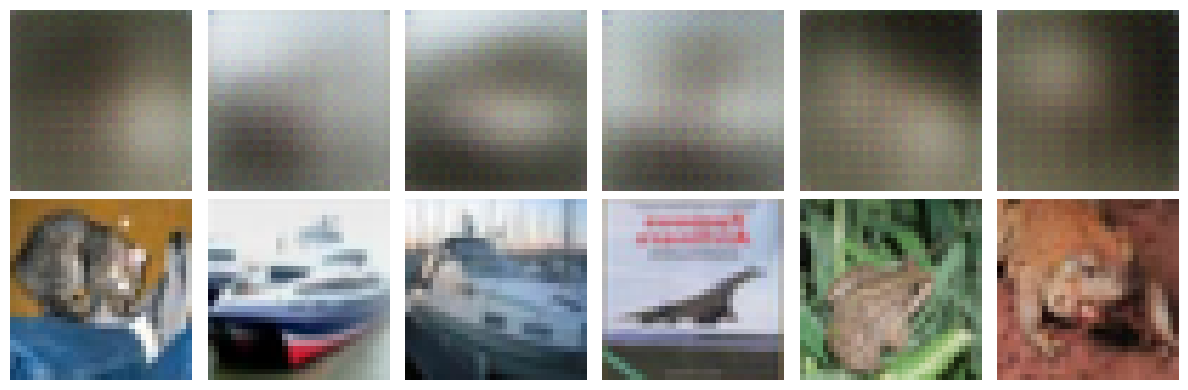

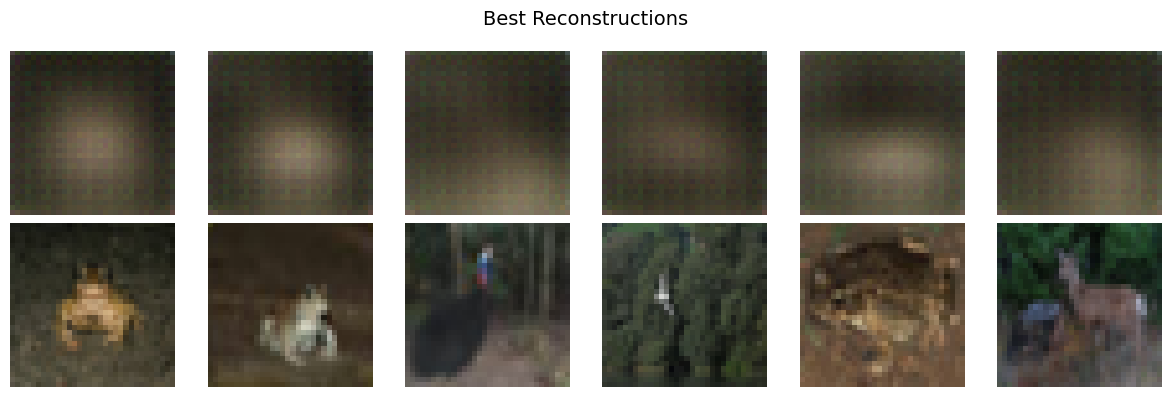

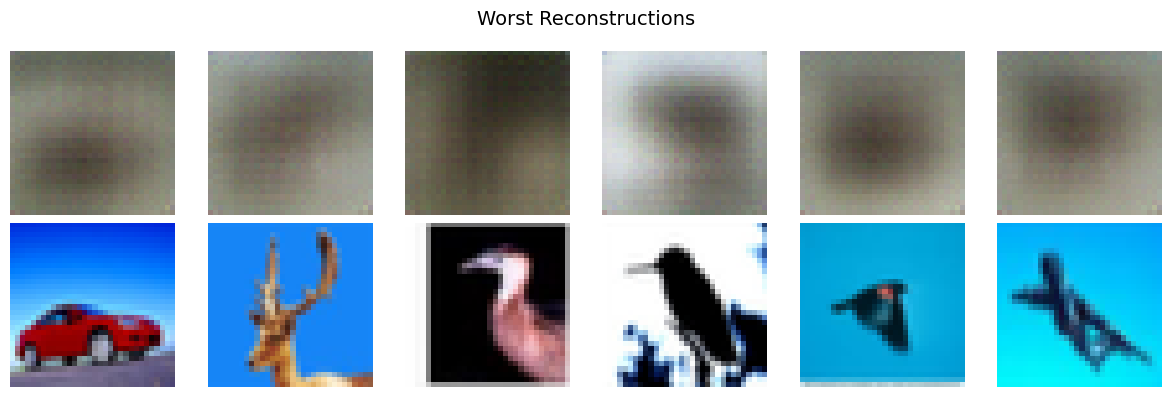

Saved best model (val_loss: 398.1078)
Saved best model (val_loss: 353.9460)
Saved best model (val_loss: 343.4375)
Saved best model (val_loss: 337.0458)
Epoch [10/500] | Beta: 1.5000 | LR: 0.001000
  Gradient norm: 1047.1425
  Batch   78/78 (100.00%) | Loss: 320.9245 | Recon: 286.4397 | KL: 22.9899
  ➤ Train: Total=337.5023, Recon=305.0702 | Val: Total=331.7202, Recon=298.1978, KL=22.3482 | Time: 19.8s
Saved best model (val_loss: 331.7202)


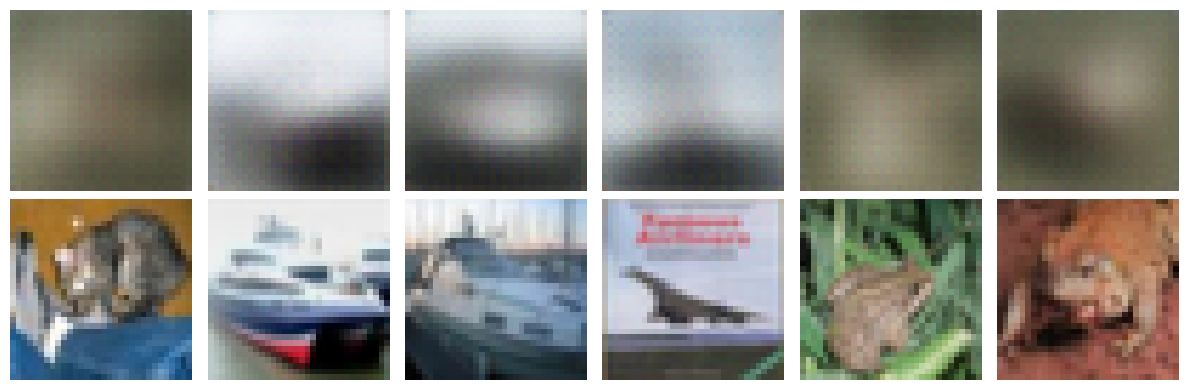

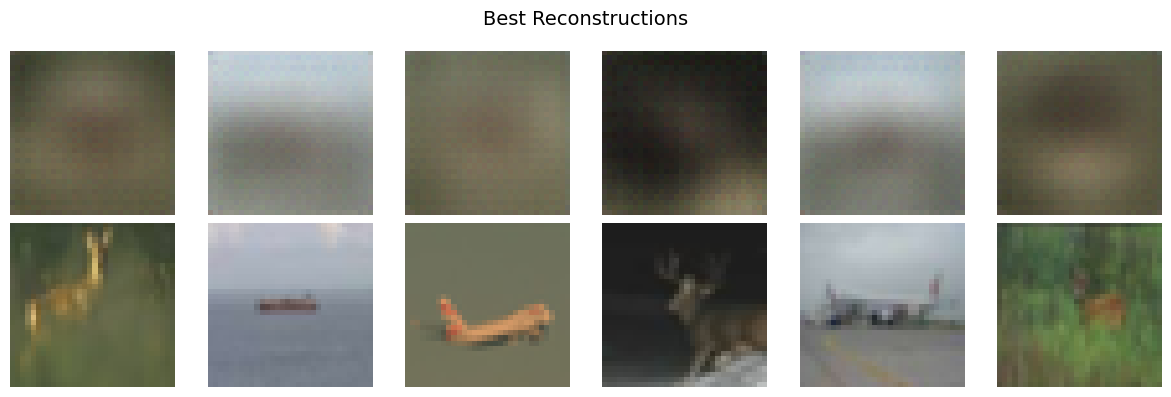

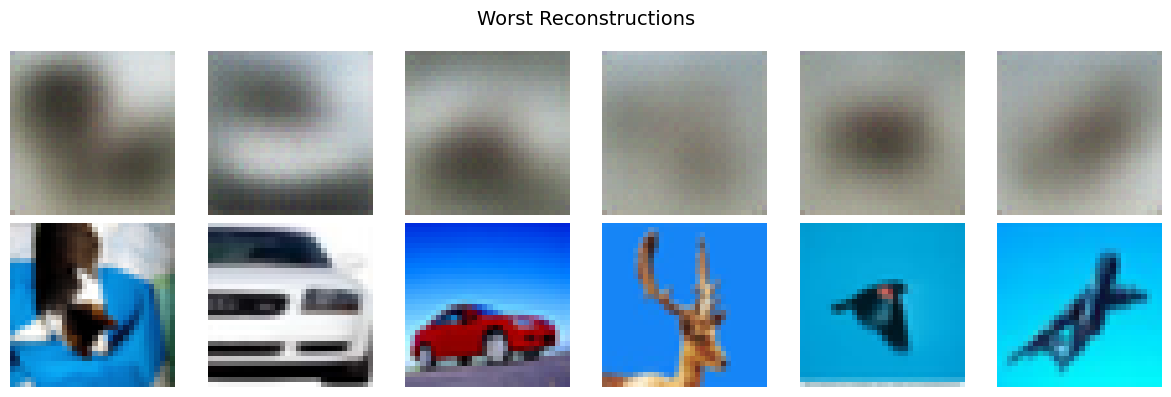

Saved best model (val_loss: 322.2661)
Saved best model (val_loss: 319.7253)
Saved best model (val_loss: 317.5544)
Epoch [15/500] | Beta: 2.3333 | LR: 0.001000
  Batch   78/78 (100.00%) | Loss: 320.1706 | Recon: 274.1094 | KL: 19.7405
  ➤ Train: Total=323.2240, Recon=277.4444 | Val: Total=322.0326, Recon=275.2460, KL=20.0514 | Time: 19.7s


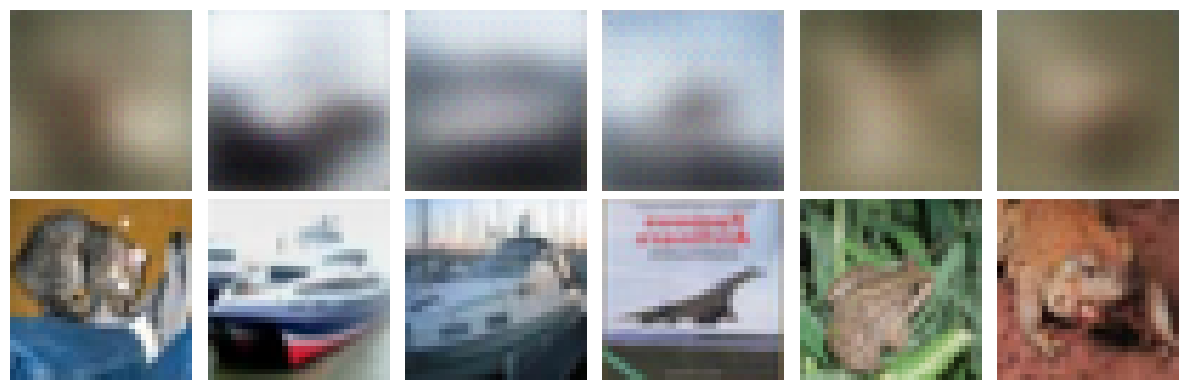

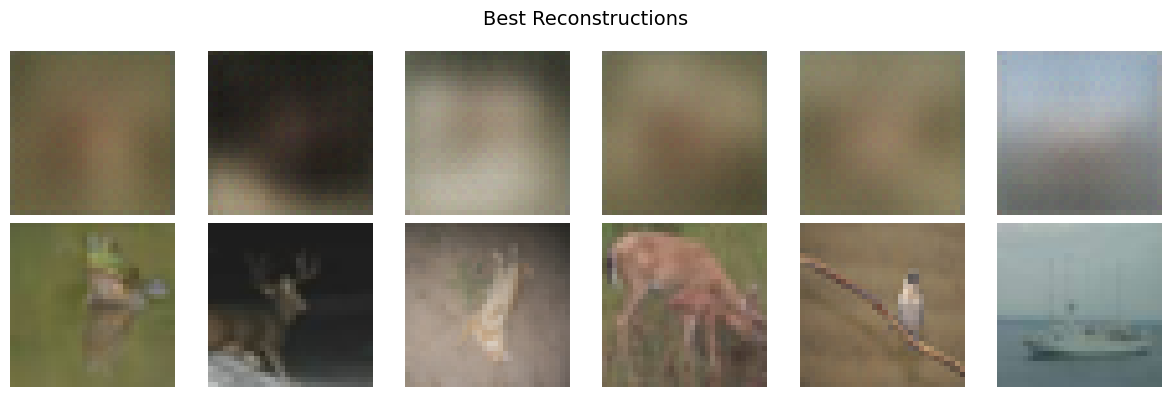

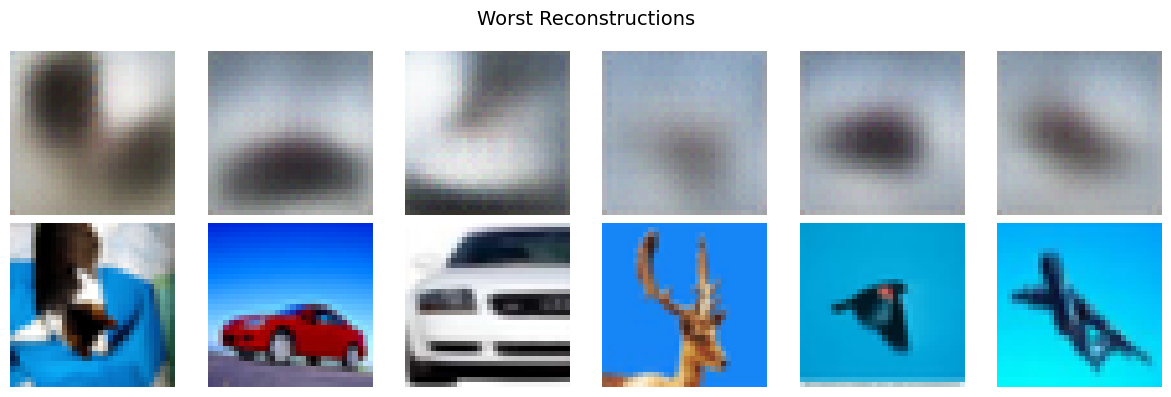

Epoch [20/500] | Beta: 3.1667 | LR: 0.001000
  Gradient norm: 985.9855
  Batch   78/78 (100.00%) | Loss: 326.2911 | Recon: 267.6281 | KL: 18.5252
  ➤ Train: Total=327.4936, Recon=271.3342 | Val: Total=322.3667, Recon=266.0841, KL=17.7734 | Time: 20.0s


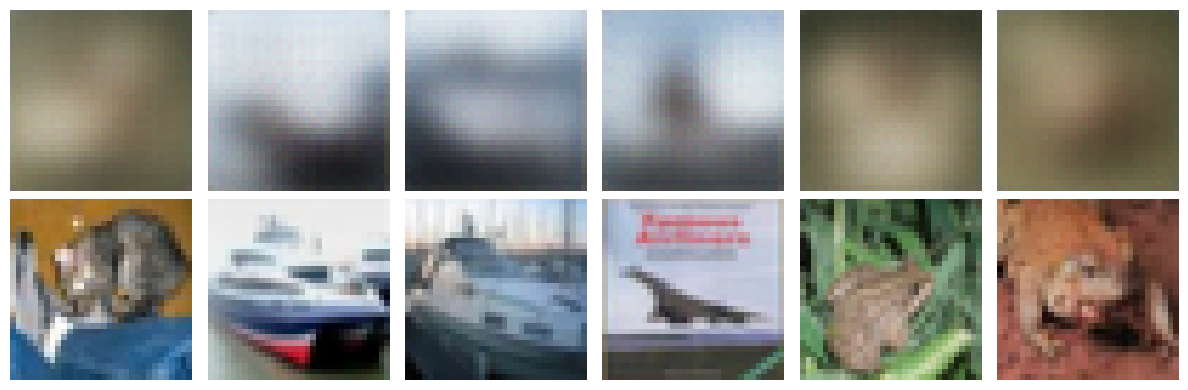

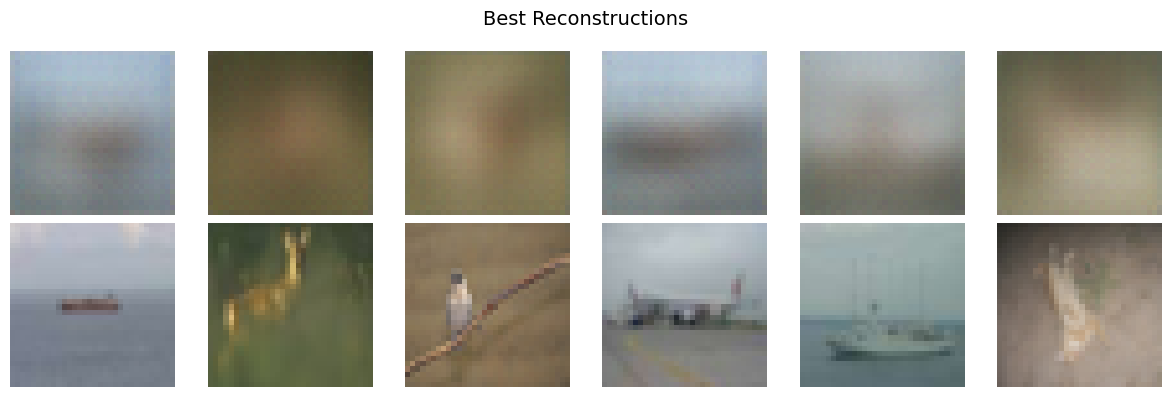

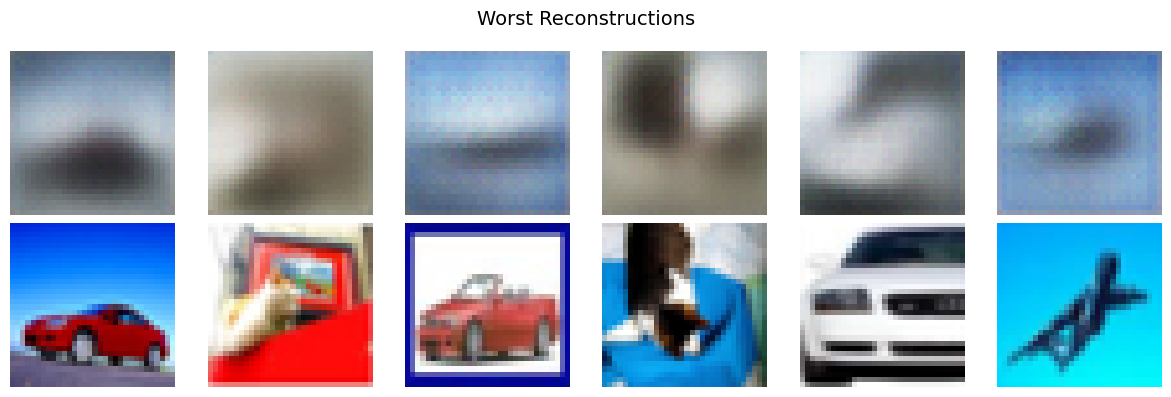

Epoch [25/500] | Beta: 4.0000 | LR: 0.001000
  Batch   78/78 (100.00%) | Loss: 318.7373 | Recon: 253.4285 | KL: 16.3272
  ➤ Train: Total=330.4432, Recon=263.6889 | Val: Total=326.3876, Recon=259.8237, KL=16.6410 | Time: 16.9s


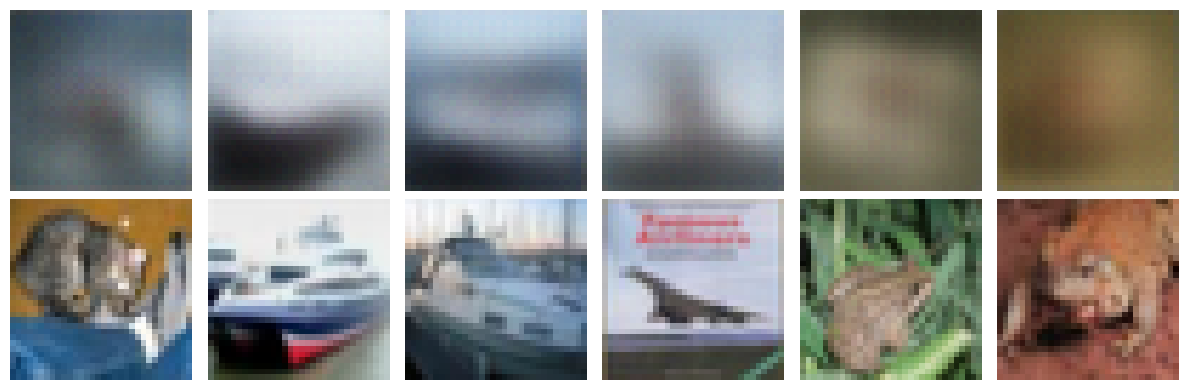

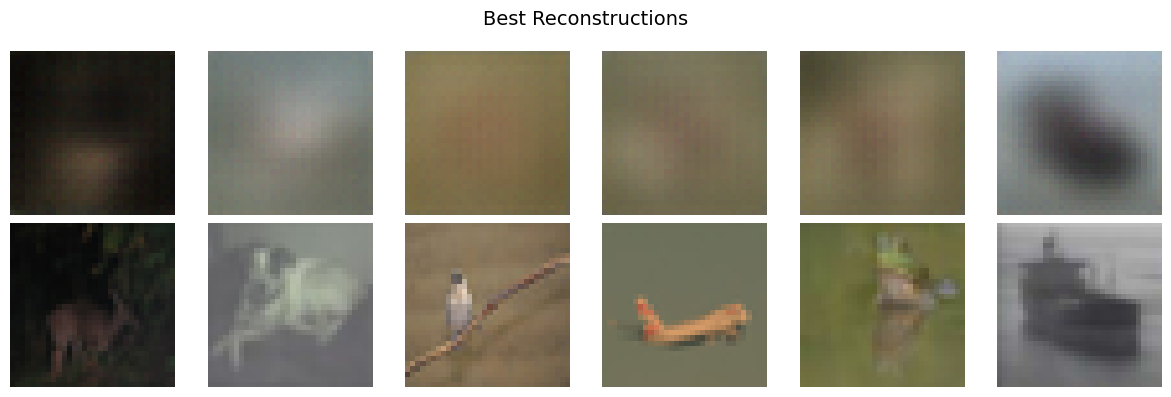

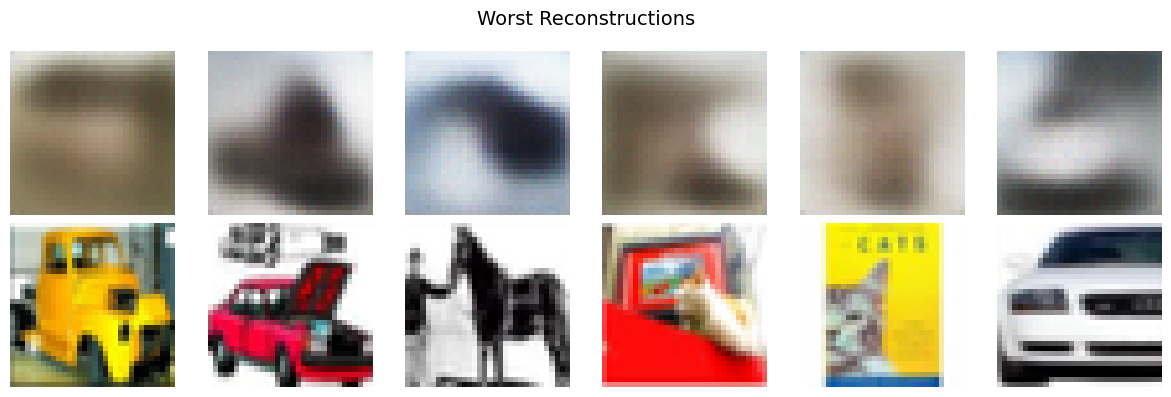

Epoch [30/500] | Beta: 4.8333 | LR: 0.000500
  Gradient norm: 682.5309
  Batch   78/78 (100.00%) | Loss: 331.9535 | Recon: 256.6465 | KL: 15.5808
  ➤ Train: Total=331.5716, Recon=255.9590 | Val: Total=331.1679, Recon=257.3811, KL=15.2662 | Time: 19.9s


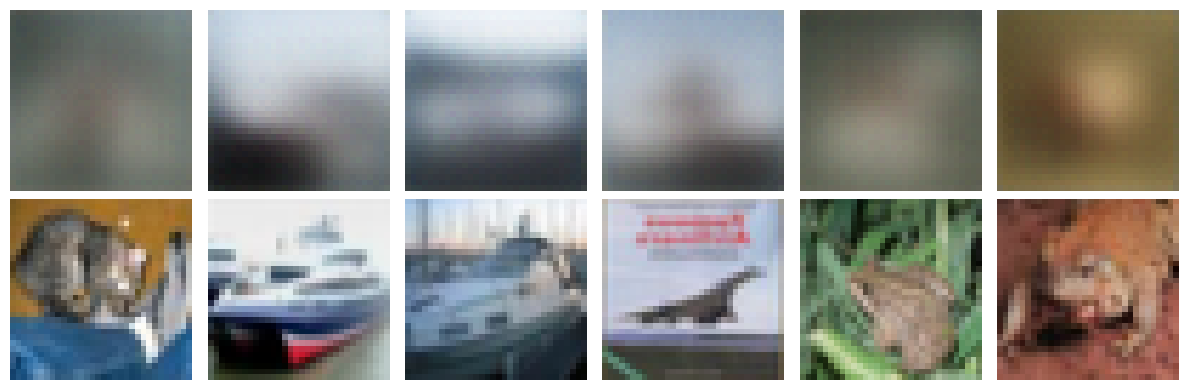

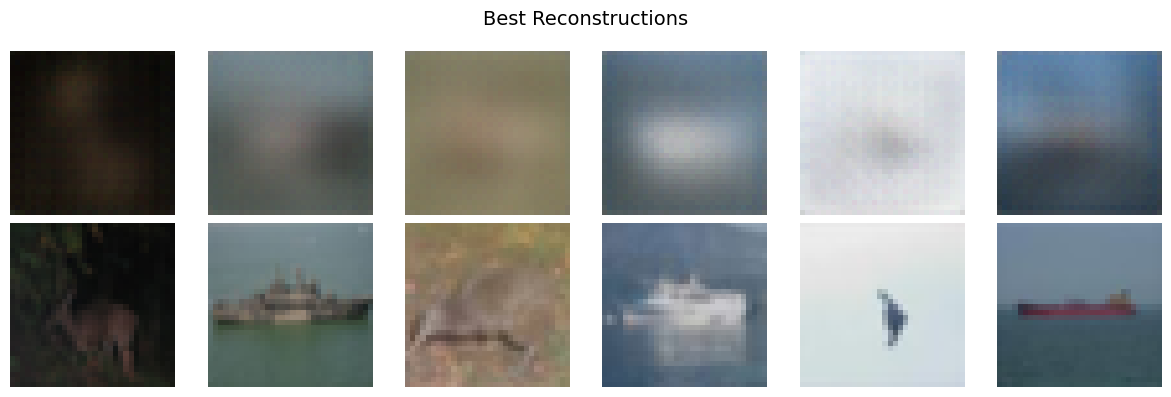

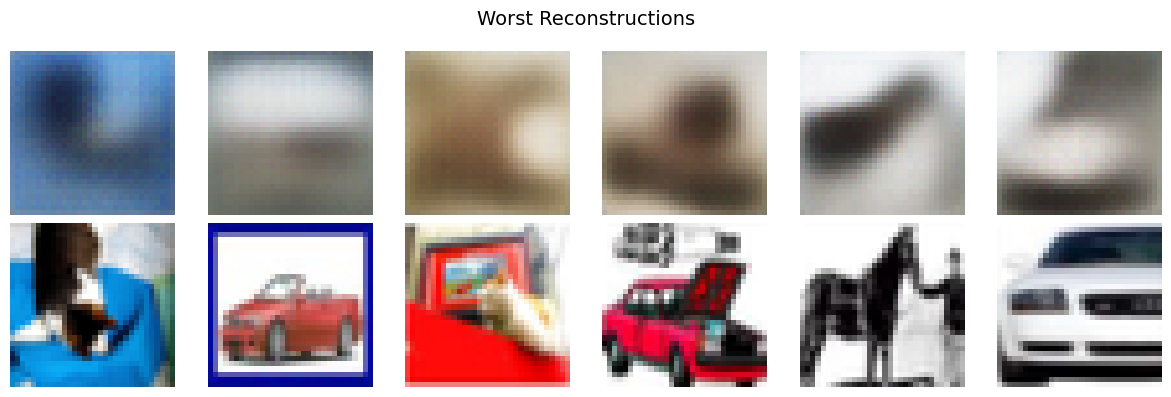


 Early stopping triggered after 34 epochs
   Best recon loss: 317.5544 at epoch 14


In [28]:

for epoch in range(num_epochs):
    # KL annealing
    current_beta = linear_annealing(epoch, warmup_epochs=warmup_epochs, max_beta=max_beta)
    current_lr = optimizer.param_groups[0]['lr']

    start_time = time.time()
    model.train()
    train_total_loss = 0.0
    train_recon_loss = 0.0 
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Beta: {current_beta:.4f} | LR: {current_lr:.6f}")
    num_batches = len(train_loader)

    for batch_idx, (imgs, _) in enumerate(train_loader, 1):
        imgs = imgs.to(device, non_blocking=True)  # Async transfer for MPS

        # Forward pass
        recon, mu, logvar = model(imgs)
        loss, recon_loss, kl_loss = vae_loss_function(recon, imgs, mu, logvar, current_beta)

        optimizer.zero_grad()
        loss.backward()
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=float('inf'))
        if (batch_idx == 1) and ((epoch + 1) % 10 == 0):
            print(f"  Gradient norm: {grad_norm:.4f}")

        # Then apply clipping only if needed
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        train_total_loss += loss.item()
        train_recon_loss += recon_loss.item()

        if batch_idx % 50 == 0 or batch_idx == num_batches:
            percent = 100 * batch_idx / num_batches
            if (epoch + 1) % 5 == 0:
                print(f"\r  Batch {batch_idx:4d}/{num_batches} "
                    f"({percent:6.2f}%) | "
                    f"Loss: {loss.item():.4f} | "
                    f"Recon: {recon_loss.item():.4f} | "
                    f"KL: {kl_loss.item():.4f}", end="")

    avg_train_total = train_total_loss / num_batches
    avg_train_recon = train_recon_loss / num_batches

    # Validation
    model.eval()
    val_total_loss = 0.0
    val_recon_loss = 0.0
    val_kl_loss = 0.0
    
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device, non_blocking=True)  # Async transfer for MPS
            recon, mu, logvar = model(imgs)
            total_l, recon_l, kl_l = vae_loss_function(recon, imgs, mu, logvar, current_beta)
            
            val_total_loss += total_l.item()
            val_recon_loss += recon_l.item()
            val_kl_loss += kl_l.item()
    
    avg_val_total = val_total_loss / len(val_loader)
    avg_val_recon = val_recon_loss / len(val_loader)
    avg_val_kl = val_kl_loss / len(val_loader)
    
    duration = time.time() - start_time
    
    # Store history
    train_losses_hist.append(avg_train_total)
    val_losses_hist.append(avg_val_total)
    train_recon_hist.append(avg_train_recon)
    val_recon_hist.append(avg_val_recon)
    val_kl_hist.append(avg_val_kl)
    learning_rates.append(current_lr)
    
    if (epoch + 1) % 5 == 0:
        print(f"\n  ➤ Train: Total={avg_train_total:.4f}, Recon={avg_train_recon:.4f} | "
              f"Val: Total={avg_val_total:.4f}, Recon={avg_val_recon:.4f}, KL={avg_val_kl:.4f} | "
              f"Time: {duration:.1f}s")

    # Step scheduler
    scheduler.step(avg_val_total)

    # Early stopping block using reconstruction loss
    if avg_val_total < best_val_loss:
        best_val_loss = avg_val_total
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'code_size': code_size,
            'train_total_loss': avg_train_total,
            'val_total_loss': avg_val_total,
            'beta': current_beta,
            'lr': current_lr,
        }, 'best_vae_model.pt')
        print(f"Saved best model (val_loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"\n Early stopping triggered after {epoch+1} epochs")
            print(f"   Best recon loss: {best_val_loss:.4f} at epoch {epoch+1-patience_counter}")
            break

    # Visualization every 5 epochs
    if (epoch + 1) % 5 == 0:
        show_reconstruction_samples(model, test_loader, n=6)
        show_best_and_worst_reconstructions(model, test_loader, device)


### Training loss and Val loss

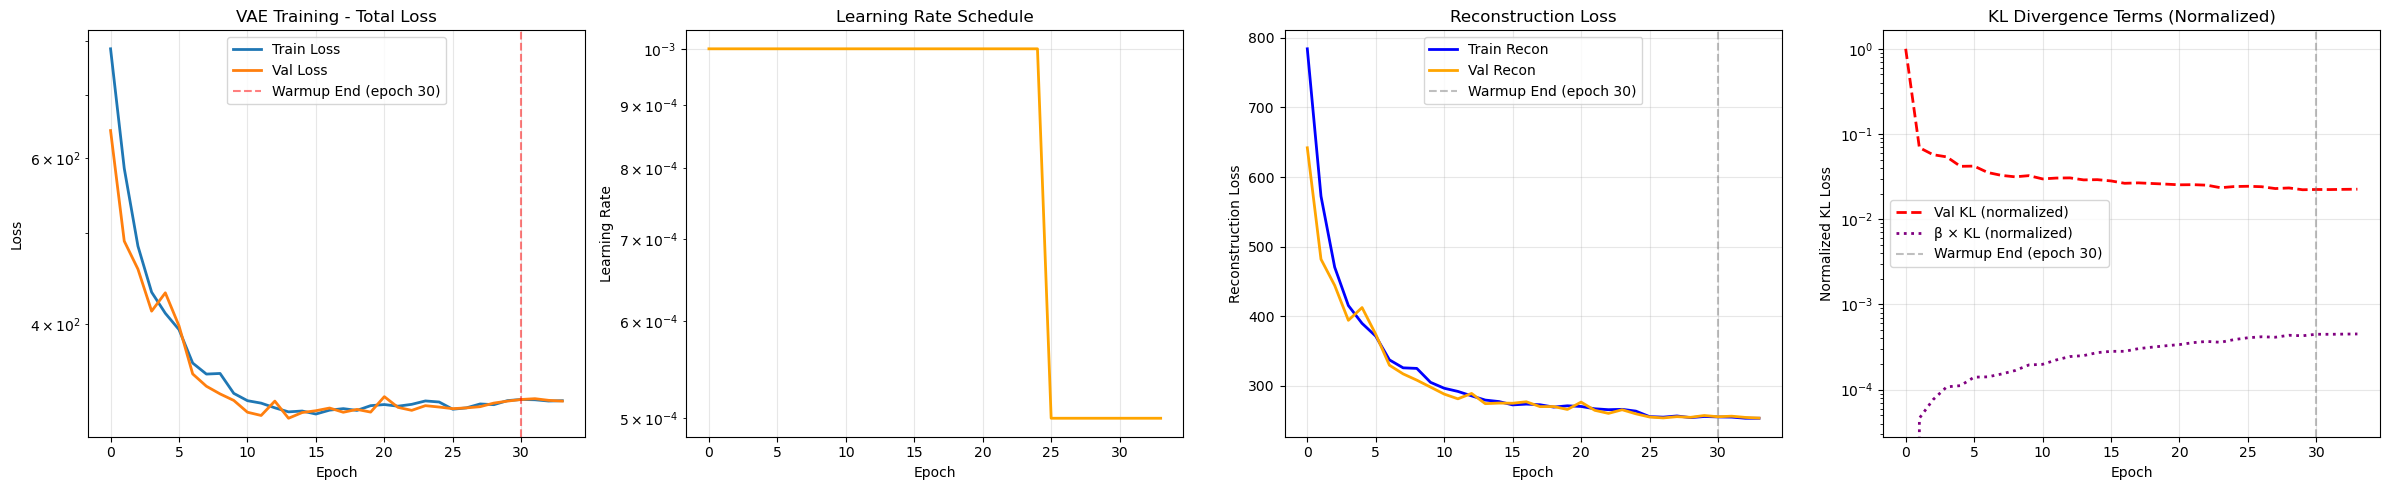

In [29]:
import matplotlib.pyplot as plt

# β annealing schedule
beta_values = [min(epoch / warmup_epochs, 1.0) * 0.02 for epoch in range(len(val_kl_hist))]

# --- Normalize KL values for readability ---
max_kl = max(val_kl_hist)
val_kl_norm = [kl / max_kl for kl in val_kl_hist]
weighted_kl_norm = [b * kl for b, kl in zip(beta_values, val_kl_norm)]

# --- Create subplots ---
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 5))

# --- 1️⃣ Total Loss ---
ax1.plot(train_losses_hist, label='Train Loss', linewidth=2)
ax1.plot(val_losses_hist, label='Val Loss', linewidth=2)
ax1.axvline(warmup_epochs, color='red', linestyle='--', alpha=0.5, label=f'Warmup End (epoch {warmup_epochs})')
ax1.set_yscale('log')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('VAE Training - Total Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# --- 2️⃣ Learning Rate Schedule ---
ax2.plot(learning_rates, linewidth=2, color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.set_yscale('log')
ax2.grid(alpha=0.3)

# --- 3️⃣ Reconstruction Loss ---
ax3.plot(train_recon_hist, label='Train Recon', linewidth=2, color='blue')
ax3.plot(val_recon_hist, label='Val Recon', linewidth=2, color='orange')
ax3.axvline(warmup_epochs, color='gray', linestyle='--', alpha=0.5, label=f'Warmup End (epoch {warmup_epochs})')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Reconstruction Loss')
ax3.set_title('Reconstruction Loss')
ax3.legend()
ax3.grid(alpha=0.3)

# --- 4️⃣ KL Divergence (Normalized) ---
ax4.plot(val_kl_norm, label='Val KL (normalized)', linestyle='--', linewidth=2, color='red')
ax4.plot(weighted_kl_norm, label='β × KL (normalized)', linestyle=':', linewidth=2, color='purple')
ax4.axvline(warmup_epochs, color='gray', linestyle='--', alpha=0.5, label=f'Warmup End (epoch {warmup_epochs})')
ax4.set_xlabel('Epoch')
ax4.set_yscale('log')
ax4.set_ylabel('Normalized KL Loss')
ax4.set_title('KL Divergence Terms (Normalized)')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Latent space analysis

✓ Extracted 10000 samples × 32 dimensions
Low-variance dims (<0.01): 7 / 32
KL-near-prior dims (<0.01): 7 / 32
Highly correlated pairs (|r|>0.7): 28


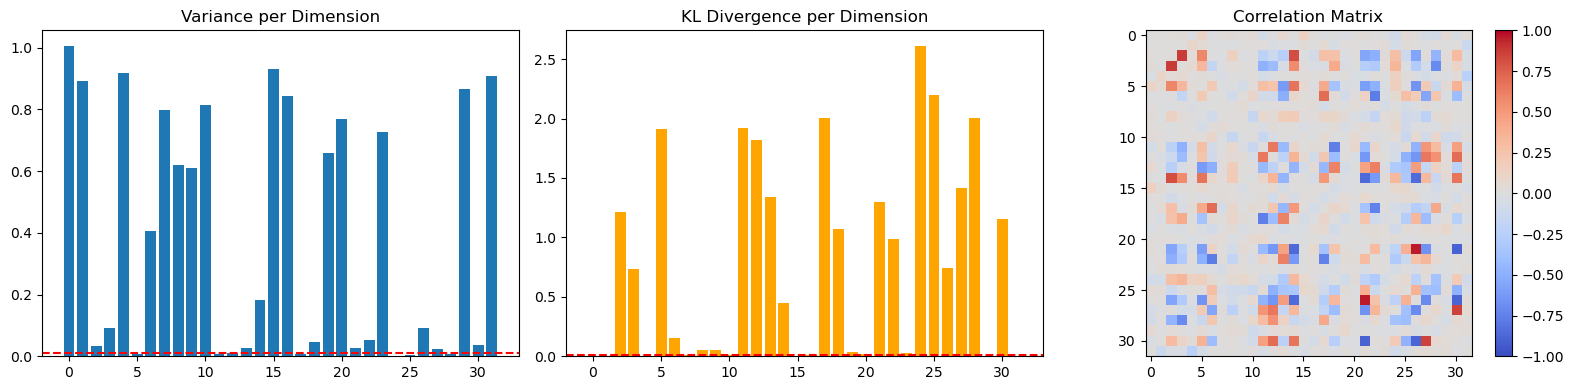

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap

# ----------------------------------------------------------------------
# Extract latent means from test set
# ----------------------------------------------------------------------
model.eval()
latent_mus = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        mu, _ = model.encode(imgs)
        latent_mus.append(mu.cpu().numpy())
        labels.extend(lbls.numpy())

latent_mus = np.concatenate(latent_mus)  # (N, latent_dim)
labels = np.array(labels)
print(f"✓ Extracted {latent_mus.shape[0]} samples × {latent_mus.shape[1]} dimensions")

# ----------------------------------------------------------------------
# 1. Variance per dimension
# ----------------------------------------------------------------------
variances = np.var(latent_mus, axis=0)
low_var_dims = np.where(variances < 0.01)[0]
print(f"Low-variance dims (<0.01): {len(low_var_dims)} / {latent_mus.shape[1]}")

# ----------------------------------------------------------------------
# 2. KL divergence approximation
# ----------------------------------------------------------------------
means = np.mean(latent_mus, axis=0)
kl = 0.5 * (variances + means**2 - 1 - np.log(variances + 1e-8))
low_kl_dims = np.where(kl < 0.01)[0]
print(f"KL-near-prior dims (<0.01): {len(low_kl_dims)} / {latent_mus.shape[1]}")

# ----------------------------------------------------------------------
# 3. Correlation analysis
# ----------------------------------------------------------------------
corr = np.corrcoef(latent_mus.T)
np.fill_diagonal(corr, 0)
redundant_pairs = np.argwhere(np.abs(corr) > 0.7)
print(f"Highly correlated pairs (|r|>0.7): {len(redundant_pairs)}")

# ----------------------------------------------------------------------
# Visualization: variance, KL, correlation
# ----------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].bar(range(len(variances)), variances)
axes[0].set_title("Variance per Dimension")
axes[0].axhline(0.01, color='r', ls='--')

axes[1].bar(range(len(kl)), kl, color='orange')
axes[1].set_title("KL Divergence per Dimension")
axes[1].axhline(0.01, color='r', ls='--')

im = axes[2].imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
axes[2].set_title("Correlation Matrix")
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()


### Dimensionality reduction: UMAP and t-SNE

/Users/homer/_mygit/cas-aml/_Miniforge/install_dir/envs/tensorflow/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


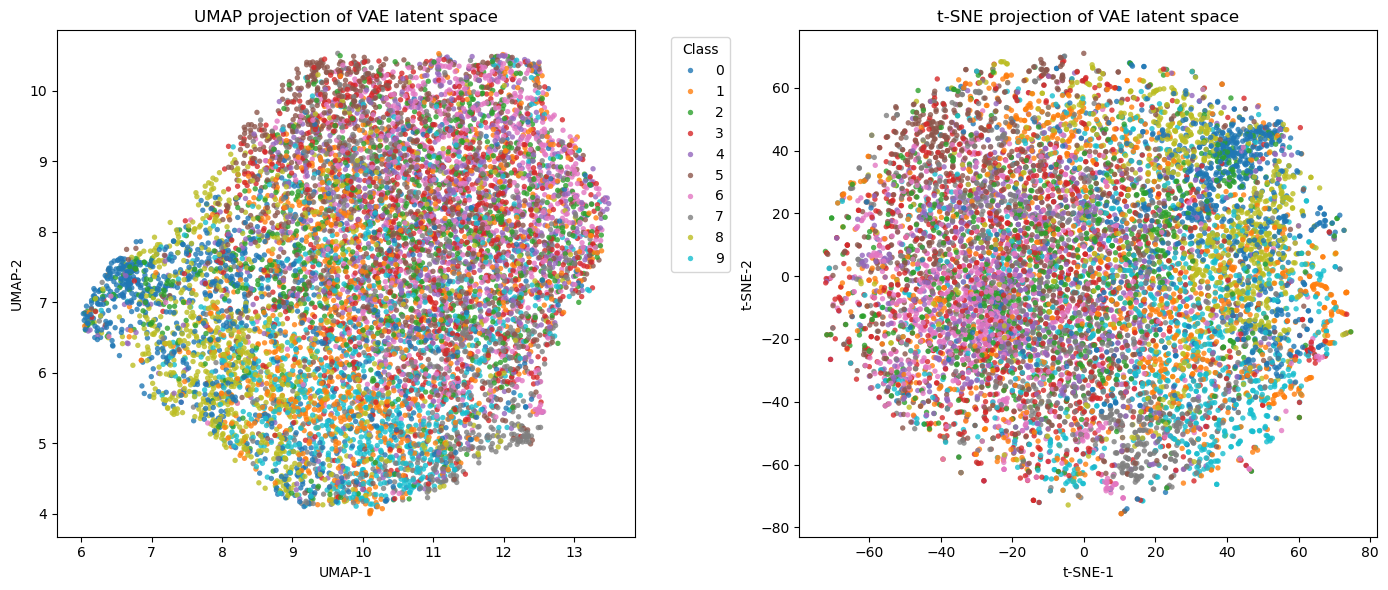

In [31]:
features = latent_mus
# --- UMAP ---
reducer_umap = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)
z_umap = reducer_umap.fit_transform(features)

# --- t-SNE ---
reducer_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)
z_tsne = reducer_tsne.fit_transform(features)

# --- Plot both side by side ---
plt.figure(figsize=(14, 6))

# UMAP subplot
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=z_umap[:, 0],
    y=z_umap[:, 1],
    hue=labels,
    palette="tab10",
    s=15,
    alpha=0.8,
    linewidth=0
)
plt.title("UMAP projection of VAE latent space")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

# t-SNE subplot
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=z_tsne[:, 0],
    y=z_tsne[:, 1],
    hue=labels,
    palette="tab10",
    s=15,
    alpha=0.8,
    linewidth=0
)
plt.title("t-SNE projection of VAE latent space")
plt.legend([], [], frameon=False)
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")

plt.tight_layout()
plt.show()



# Classification on Latent Space

Now we'll train classifiers using the VAE's learned latent representations.

**Goal**: Use the X-dimensional latent vectors (instead of 3,072 raw pixels) to classify CIFAR-10 images.

**Why**: This demonstrates that the VAE learned meaningful features during unsupervised training.

## Extraction

### Extract latent features for training set

In [32]:
model.eval()

train_latent_features = []
train_latent_labels = []

with torch.no_grad():
    for imgs, labels in tqdm.tqdm(train_loader, desc="Training set"):
        imgs = imgs.to(device)
        mu, _ = model.encode(imgs)
        train_latent_features.append(mu.cpu().numpy())
        train_latent_labels.append(labels.numpy())

train_latent_features = np.concatenate(train_latent_features)
train_latent_labels = np.concatenate(train_latent_labels)

print(f"Training features shape: {train_latent_features.shape}")
print(f"Training labels shape: {train_latent_labels.shape}")
print(f"Dimensionality reduction: {3*32*32} pixels → {train_latent_features.shape[1]} features ({3*32*32/train_latent_features.shape[1]:.1f}x smaller)")

Training set:   0%|          | 0/78 [00:00<?, ?it/s]

Training features shape: (39936, 32)
Training labels shape: (39936,)
Dimensionality reduction: 3072 pixels → 32 features (96.0x smaller)


### Dimension Verification: Ensure extracted features match expected code_size

In [33]:
print("="*60 + "\n")
print(f"Expected latent dimension (code_size): {code_size}")
print(f"Actual extracted features dimension: {train_latent_features.shape[1]}")
print("="*60 + "\n")

if train_latent_features.shape[1] != code_size:
    print(f"WARNING: Dimension Mismatch Detected!")
else:
    print(f"Dimension match")
    
print("="*60 + "\n")


Expected latent dimension (code_size): 32
Actual extracted features dimension: 32

Dimension match



### Extract latent features for validation set

In [34]:
val_latent_features = []
val_latent_labels = []

with torch.no_grad():
    for imgs, labels in tqdm.tqdm(val_loader, desc="Validation set"):
        imgs = imgs.to(device)
        mu, _ = model.encode(imgs)
        val_latent_features.append(mu.cpu().numpy())
        val_latent_labels.append(labels.numpy())

val_latent_features = np.concatenate(val_latent_features)
val_latent_labels = np.concatenate(val_latent_labels)

print(f"Validation features shape: {val_latent_features.shape}")
print(f"Validation labels shape: {val_latent_labels.shape}")

Validation set:   0%|          | 0/20 [00:00<?, ?it/s]

Validation features shape: (10000, 32)
Validation labels shape: (10000,)


### Extract latent features for test set  

In [35]:
test_latent_features = []
test_latent_labels = []

with torch.no_grad():
    for imgs, labels in tqdm.tqdm(test_loader, desc="Test set"):
        imgs = imgs.to(device)
        mu, _ = model.encode(imgs)
        test_latent_features.append(mu.cpu().numpy())
        test_latent_labels.append(labels.numpy())

test_latent_features = np.concatenate(test_latent_features)
test_latent_labels = np.concatenate(test_latent_labels)

print(f"Test features shape: {test_latent_features.shape}")
print(f"Test labels shape: {test_latent_labels.shape}")

Test set:   0%|          | 0/20 [00:00<?, ?it/s]

Test features shape: (10000, 32)
Test labels shape: (10000,)


## Train Logistic Regression on latent features

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

print("="*60)
print("Training Logistic Regression Classifier")
print("="*60)

start_time = time.time()
logreg_clf = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42,
    verbose=1
)

logreg_clf.fit(train_latent_features, train_latent_labels)
training_time = time.time() - start_time

print(f"\nTraining completed in {training_time:.2f} seconds")

# Evaluate on train, val, test
train_pred = logreg_clf.predict(train_latent_features)
val_pred = logreg_clf.predict(val_latent_features)
test_pred = logreg_clf.predict(test_latent_features)

logreg_train_acc = accuracy_score(train_latent_labels, train_pred)
logreg_val_acc = accuracy_score(val_latent_labels, val_pred)
logreg_test_acc = accuracy_score(test_latent_labels, test_pred)

print(f"Train Accuracy: {logreg_train_acc:.2%}")
print(f"Val Accuracy:   {logreg_val_acc:.2%}")
print(f"Test Accuracy:  {logreg_test_acc:.2%}")
print("="*60)

Training Logistic Regression Classifier


/Users/homer/_mygit/cas-aml/_Miniforge/install_dir/envs/tensorflow/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Training completed in 1.65 seconds
Train Accuracy: 33.01%
Val Accuracy:   33.35%
Test Accuracy:  33.28%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


### Report for Logistic Regression Classifier

In [37]:
print(classification_report(
    test_latent_labels, 
    test_pred,
    target_names=cifar10_classes
))

              precision    recall  f1-score   support

    airplane       0.42      0.49      0.45      1000
  automobile       0.35      0.35      0.35      1000
        bird       0.24      0.18      0.20      1000
         cat       0.24      0.15      0.18      1000
        deer       0.25      0.19      0.22      1000
         dog       0.32      0.36      0.34      1000
        frog       0.31      0.43      0.36      1000
       horse       0.29      0.25      0.27      1000
        ship       0.41      0.48      0.45      1000
       truck       0.38      0.45      0.41      1000

    accuracy                           0.33     10000
   macro avg       0.32      0.33      0.32     10000
weighted avg       0.32      0.33      0.32     10000



### Confusion matrix

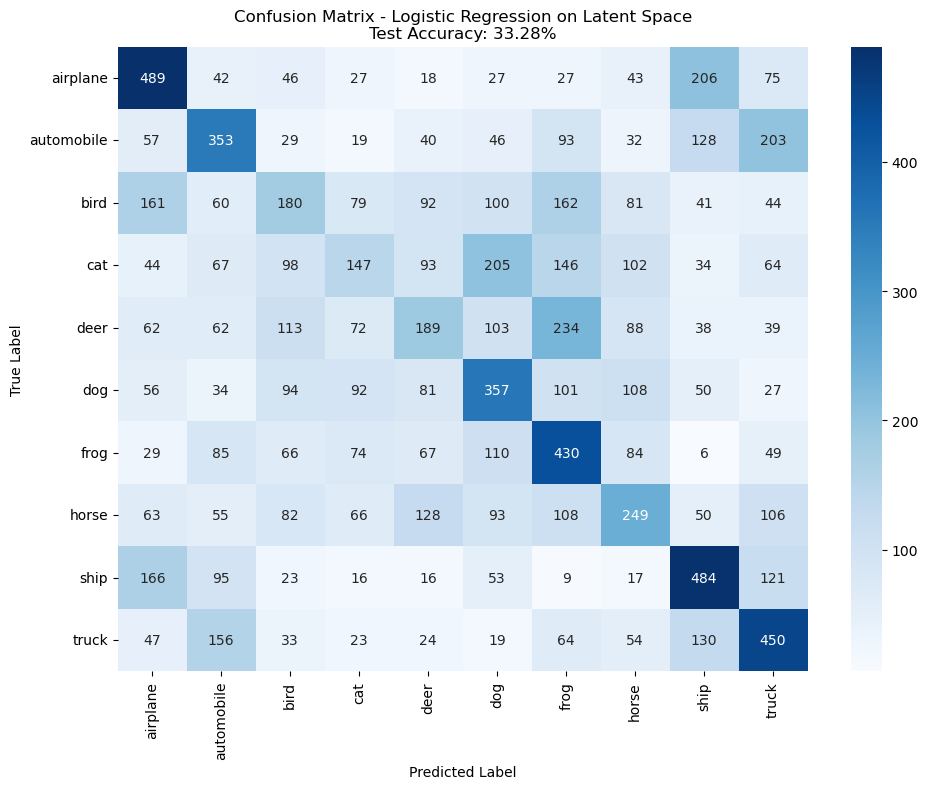

In [38]:
cm = confusion_matrix(test_latent_labels, test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cifar10_classes,
            yticklabels=cifar10_classes)
plt.title(f'Confusion Matrix - Logistic Regression on Latent Space\nTest Accuracy: {logreg_test_acc:.2%}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Define MLP Classifier for latent features

In [39]:
class LatentClassifier(nn.Module):
    """MLP classifier for VAE latent space"""
    def __init__(self, latent_dim=code_size, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

actual_latent_dim = train_latent_features.shape[1]

mlp_classifier = LatentClassifier(latent_dim=actual_latent_dim, num_classes=10).to(device)
test_input = torch.randn(4, actual_latent_dim).to(device)
test_output = mlp_classifier(test_input)

print(f"Input shape: {test_input.shape} → Output shape: {test_output.shape}")
print(f"Total parameters: {sum(p.numel() for p in mlp_classifier.parameters()):,}")

Input shape: torch.Size([4, 32]) → Output shape: torch.Size([4, 10])
Total parameters: 184,202


## Train MLP classifier on latent features

In [40]:
import torch.utils.data as data_utils

print("="*60)
print("Training MLP Classifier on Latent Features")
print("="*60)

# Create datasets from numpy arrays
train_dataset = data_utils.TensorDataset(
    torch.from_numpy(train_latent_features).float(),
    torch.from_numpy(train_latent_labels).long()
)
val_dataset = data_utils.TensorDataset(
    torch.from_numpy(val_latent_features).float(),
    torch.from_numpy(val_latent_labels).long()
)
test_dataset = data_utils.TensorDataset(
    torch.from_numpy(test_latent_features).float(),
    torch.from_numpy(test_latent_labels).long()
)

# Create dataloaders
train_clf_loader = data_utils.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_clf_loader = data_utils.DataLoader(val_dataset, batch_size=256, shuffle=False)
test_clf_loader = data_utils.DataLoader(test_dataset, batch_size=256, shuffle=False)

# Initialize model and optimizer
mlp_classifier = LatentClassifier(latent_dim=actual_latent_dim, num_classes=10).to(device)
optimizer_clf = torch.optim.Adam(mlp_classifier.parameters(), lr=1e-3, weight_decay=1e-4)
criterion_clf = nn.CrossEntropyLoss()

# Training loop
num_epochs_clf = 150
best_val_acc = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs_clf):
    mlp_classifier.train()
    train_loss, train_correct, train_total = 0, 0, 0
    
    for features, labels in train_clf_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer_clf.zero_grad()
        outputs = mlp_classifier(features)
        loss = criterion_clf(outputs, labels)
        loss.backward()
        optimizer_clf.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # Validation
    mlp_classifier.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    
    with torch.no_grad():
        for features, labels in val_clf_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = mlp_classifier(features)
            loss = criterion_clf(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate metrics
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    avg_train_loss = train_loss / len(train_clf_loader)
    avg_val_loss = val_loss / len(val_clf_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(mlp_classifier.state_dict(), 'best_latent_classifier.pt')
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1:2d}/{num_epochs_clf}] | "
              f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%")

print(f"\n✓ Best Validation Accuracy: {best_val_acc:.2f}%")
print("="*60)

Training MLP Classifier on Latent Features
Epoch [ 5/150] | Train Loss: 1.6821, Acc: 39.48% | Val Loss: 1.5935, Acc: 43.28%
Epoch [10/150] | Train Loss: 1.6335, Acc: 41.43% | Val Loss: 1.5629, Acc: 43.82%
Epoch [15/150] | Train Loss: 1.6004, Acc: 42.63% | Val Loss: 1.5509, Acc: 44.76%
Epoch [20/150] | Train Loss: 1.5781, Acc: 43.58% | Val Loss: 1.5334, Acc: 45.47%
Epoch [25/150] | Train Loss: 1.5596, Acc: 44.30% | Val Loss: 1.5193, Acc: 45.64%
Epoch [30/150] | Train Loss: 1.5495, Acc: 44.59% | Val Loss: 1.5142, Acc: 46.43%
Epoch [35/150] | Train Loss: 1.5320, Acc: 45.20% | Val Loss: 1.5090, Acc: 46.00%
Epoch [40/150] | Train Loss: 1.5201, Acc: 45.86% | Val Loss: 1.5069, Acc: 46.28%
Epoch [45/150] | Train Loss: 1.5080, Acc: 46.15% | Val Loss: 1.5000, Acc: 46.78%
Epoch [50/150] | Train Loss: 1.5005, Acc: 46.45% | Val Loss: 1.5033, Acc: 46.84%
Epoch [55/150] | Train Loss: 1.4956, Acc: 46.29% | Val Loss: 1.5007, Acc: 46.90%
Epoch [60/150] | Train Loss: 1.4848, Acc: 46.96% | Val Loss: 1.497

### Load best model and evaluate on test set

In [41]:
mlp_classifier.load_state_dict(torch.load('best_latent_classifier.pt'))
mlp_classifier.eval()

test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for features, labels in test_clf_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = mlp_classifier(features)
        _, predicted = torch.max(outputs.data, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

mlp_test_acc = 100 * test_correct / test_total

print("="*60)
print("MLP Classifier Test Results")
print("="*60)
print(f"Test Accuracy: {mlp_test_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=cifar10_classes))

MLP Classifier Test Results
Test Accuracy: 46.82%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.58      0.53      0.55      1000
  automobile       0.52      0.57      0.55      1000
        bird       0.36      0.28      0.31      1000
         cat       0.32      0.31      0.32      1000
        deer       0.39      0.33      0.36      1000
         dog       0.44      0.35      0.39      1000
        frog       0.45      0.57      0.50      1000
       horse       0.51      0.52      0.51      1000
        ship       0.57      0.66      0.61      1000
       truck       0.49      0.57      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000



### Confusion matrix

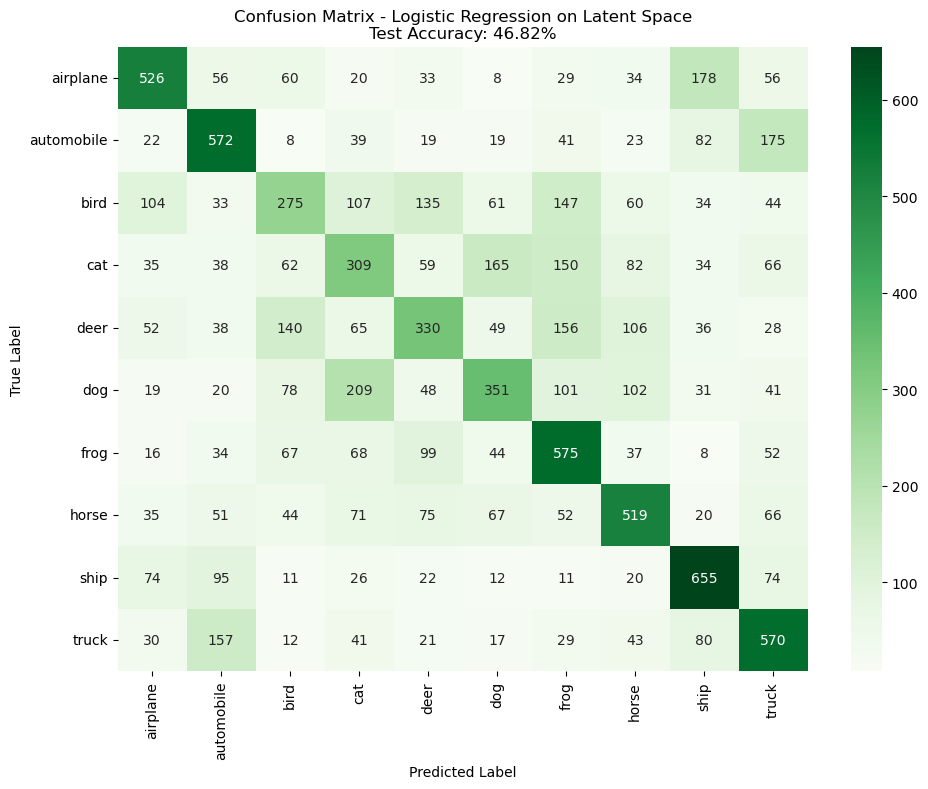

In [42]:
cm_mlp = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens',
            xticklabels=cifar10_classes,
            yticklabels=cifar10_classes)
plt.title(f'Confusion Matrix - Logistic Regression on Latent Space\nTest Accuracy: {mlp_test_acc:.2f}%')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Summary comparison

In [43]:
results = pd.DataFrame({
    'Method': ['Logistic Regression', 'MLP Classifier'],
    'Input Dimension': [actual_latent_dim, actual_latent_dim],
    'Train Accuracy': [f"{logreg_train_acc*100:.2f}%", f"{train_accs[-1]:.2f}%"],
    'Val Accuracy': [f"{logreg_val_acc*100:.2f}%", f"{val_accs[-1]:.2f}%"],
    'Test Accuracy': [f"{logreg_test_acc*100:.2f}%", f"{mlp_test_acc:.2f}%"]
})

print(results.to_string(index=False))
print("="*70)

             Method  Input Dimension Train Accuracy Val Accuracy Test Accuracy
Logistic Regression               32         33.01%       33.35%        33.28%
     MLP Classifier               32         48.80%       47.03%        46.82%
